In [1]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

<Axes: xlabel='Date'>

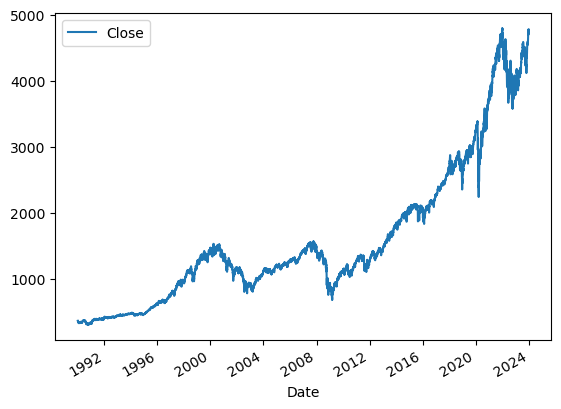

In [2]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
del sp500["Dividends"]
del sp500["Stock Splits"]
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.loc["1990-01-01":].copy()
sp500.plot.line(y="Close", use_index=True)

In [3]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=100, random_state=1)
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]
predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, n_estimators=200, random_state=1)

In [4]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [5]:
precision_score(test["Target"], preds)

0.5238095238095238

<Axes: xlabel='Date'>

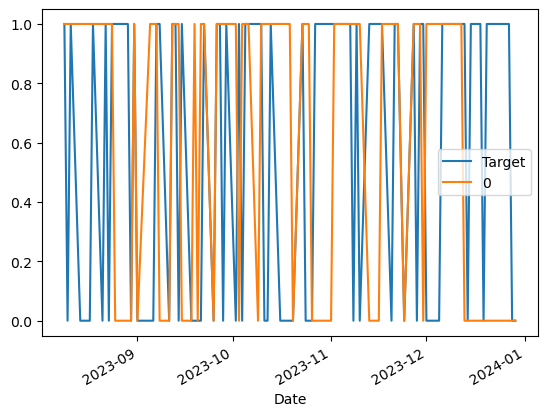

In [6]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [7]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined


def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i : (i + step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [8]:
predictions = backtest(sp500, model, predictors)

In [9]:
predictions["Predictions"].value_counts()

Predictions
0    3401
1    2664
Name: count, dtype: int64

In [10]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5266516516516516

In [11]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.534542
0    0.465458
Name: count, dtype: float64

In [12]:
# add more predictiors to the model
# we can do this by adding some rolling averages
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]
    # we can do this before we take out the days before 1990 so that we can have complete rolling averages

sp500 = sp500.dropna()

In [13]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21 00:00:00-05:00,4724.290039,4748.709961,4708.350098,4746.750000,3431180000,4754.629883,1,1.005124,1.0,1.002557,3.0,1.070644,37.0,1.112992,135.0,1.197601,528.0
2023-12-22 00:00:00-05:00,4753.919922,4772.939941,4736.770020,4754.629883,3046770000,4774.750000,1,1.000829,2.0,1.002720,4.0,1.070590,37.0,1.113889,135.0,1.199129,529.0
2023-12-26 00:00:00-05:00,4758.859863,4784.720215,4758.450195,4774.750000,2513910000,4781.580078,1,1.002111,2.0,1.005513,4.0,1.073161,38.0,1.117612,136.0,1.203740,529.0


In [14]:
model = RandomForestClassifier(n_estimators=300, min_samples_split=50, random_state=1)

In [15]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:, 1]  # returns probabiltiy up
    preds[preds >= 0.6] = 1
    preds[preds <= 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [16]:
predictions = backtest(sp500, model, new_predictors)

In [17]:
predictions["Predictions"].value_counts()

Predictions
0.0    4265
1.0     799
Name: count, dtype: int64

In [18]:
precision_score(predictions["Target"], predictions["Predictions"])

0.571964956195244

In [ ]:
# to improve maybe look at stoks that are changing before the index or maybe add in inflation numbers or other macro data or maybe add in individual stocks or other indexes or increase the resolution